In [240]:
import copy
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from PIL import Image
import torch.nn.functional as F

In [241]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 3)
        self.bn1 = nn.BatchNorm2d(3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(3, 6, 3)
        self.bn2 = nn.BatchNorm2d(6)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(6, 12, 3)
        self.bn3 = nn.BatchNorm2d(12)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.conv4 = nn.Conv2d(12, 24, 3)
        self.bn4 = nn.BatchNorm2d(24)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.relu4 = nn.ReLU(inplace=True)
        
        #self.conv5 = nn.Conv2d(24, 48, 3)
        #self.bn5 = nn.BatchNorm2d(48)
        #self.maxpool5 = nn.MaxPool2d(kernel_size=2)
        #self.relu5 = nn.ReLU(inplace=True)

        self.fc1 = nn.Linear(24 * 29 * 29, 150)
        self.relu6 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(150, 3)
        self.softmax1 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.maxpool3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.maxpool4(x)
        x = self.relu4(x)
        
        #x = self.conv5(x)
        #x = self.bn5(x)
        #x = self.maxpool5(x)
        #x = self.relu5(x)
        
        x = x.view(-1, 24 * 29 * 29) 
        x = self.fc1(x)
        x = self.relu6(x)

        x = F.dropout(x, training=self.training)

        x_species = self.fc2(x)
        x_species = self.softmax1(x_species)

        return x_species

In [242]:
# set constants
FILE_DIR = {'train': '../Dataset/train/', 'val': '../Dataset/val/'}
ANNO_FILE = {'train': 'Species_train_annotation.csv', 'val': 'Species_val_annotation.csv'}
NORM_PARAMS = 'Species_Norm_Params.csv'
SPECIES = ['chickens', 'rabbits', 'rats']

In [243]:
class MyDataset:
    # define __init__
    def __init__(self, file_dir, anno_file, transform=None):
        self.file_dir = file_dir
        self.anno_file = anno_file
        self.transform = transform
        if not os.path.isfile(self.anno_file):
            print(self.anno_file + 'does not exist!')
        self.file_info = pd.read_csv(anno_file, index_col=0)
        self.size = len(self.file_info)
    # define __len__
    def __len__(self):
        return self.size
    # define __getitem__
    def __getitem__(self, idx):
        # get image
        path = self.file_info['path'][idx]
        if not os.path.isfile(path):
            print(path + ' does not exist!')
            return None
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # get annotation
        species = int(self.file_info['species'][idx])
        # make sample as dictionary and return sample
        sample = {'image': image, 'species': species}
        return sample

In [244]:
norm_params = pd.read_csv(NORM_PARAMS, index_col=0)

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(500),
        transforms.Resize((500, 500)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(eval(norm_params['train']['means']),
                             eval(norm_params['train']['stds']))
    ]),
    'val': transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize(eval(norm_params['val']['means']),
                             eval(norm_params['val']['stds']))
    ])
}

datasets = {x: MyDataset(file_dir=FILE_DIR[x],
                         anno_file=ANNO_FILE[x],
                         transform=data_transforms[x])
            for x in ['train', 'val']}

train_loader = DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=datasets['val'])
data_loaders = {'train': train_loader, 'val': test_loader}

# get device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

Current device: cuda:1


The 1480th sample: size is torch.Size([3, 500, 500]) , species is rats.


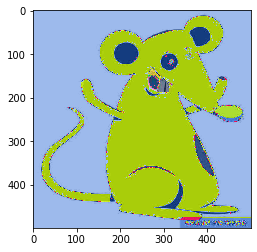

In [245]:
# define function show_random_data
def show_random_data():
    idx = random.randint(0, len(datasets['train']))
    sample = train_loader.dataset[idx]
    print('The ' + str(idx+1) + 'th sample: size is', sample['image'].shape,
           ', species is ' + SPECIES[sample['species']] + '.')
    img = sample['image']
    plt.imshow(transforms.ToPILImage()(img))
    plt.show()

# call function to visualize some data
show_random_data()

In [246]:
# define function train_model
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    # initialize variables
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_list = {'train': [], 'val': []}
    acc_list_species = {'train': [], 'val': []}

    # loop train process for num_epoches times
    for epoch in range(num_epochs):
        print('=' * 20 + ' Epoch {}/{} '.format(epoch + 1, num_epochs) + '=' * 20)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # initialize variables
            running_loss = 0.0
            corrects_species = 0

            # set model for different mode in different phases
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaluate mode

            # iterate over data batch
            for data in data_loaders[phase]:
                # get data
                inputs = data['image'].to(device)
                labels_species = data['species'].to(device)

                # clear the gradients in optimizer
                optimizer.zero_grad()

                # forward propagation
                with torch.set_grad_enabled(phase == 'train'):
                    # predict labels
                    x_species = model(inputs)
                    _, preds_species = torch.max(x_species.view(-1, 3), 1)

                    # calculate loss for this batch
                    loss = criterion(x_species, labels_species)

                    # backward propagation and optimize in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # add loss and correct num of this batch to epoch variables
                running_loss += loss.item() * inputs.size(0)
                corrects_species += torch.sum(preds_species == labels_species)

            # calculate loss and accurate for current epoch
            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = corrects_species.double() / len(data_loaders[phase].dataset)
            print('{} loss: {:.4f}, species accurate: {:.2%}. '.
                    format(phase, epoch_loss, epoch_acc))

            # record loss and accurate in list
            loss_list[phase].append(epoch_loss)
            acc_list_species[phase].append(100 * epoch_acc)

            # scheduler move a step in training phase
            #if phase == 'train':
            #    scheduler.step()

            # evaluate model in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                print('* Current best model accurate is {:.2%}. '.format(best_acc))

    # training end, save outcomes and return
    print('Best val accurate is {:.2%}. '.format(best_acc))
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), 'best_model.pt')
    print('Best model saved as best_model.pt! ')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s. '.format(
        time_elapsed // 60, time_elapsed % 60))
    return model, loss_list, acc_list_species

In [247]:
# set params and call train_model
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
num_epochs = 50
model, loss_list, acc_list_species = train_model(network, criterion, optimizer, exp_lr_scheduler, num_epochs)

==================== Epoch 1/50 ====================
train loss: 1.0653, species accurate: 43.20%. 
val loss: 1.0502, species accurate: 43.75%. 
* Current best model accurate is 43.75%. 
==================== Epoch 2/50 ====================
train loss: 1.0429, species accurate: 48.71%. 
val loss: 1.0179, species accurate: 52.50%. 
* Current best model accurate is 52.50%. 
==================== Epoch 3/50 ====================
train loss: 0.9976, species accurate: 52.81%. 
val loss: 0.9709, species accurate: 53.75%. 
* Current best model accurate is 53.75%. 
==================== Epoch 4/50 ====================
train loss: 0.9764, species accurate: 55.34%. 
val loss: 0.9889, species accurate: 55.00%. 
* Current best model accurate is 55.00%. 
==================== Epoch 5/50 ====================
train loss: 0.9834, species accurate: 55.22%. 
val loss: 0.9287, species accurate: 60.00%. 
* Current best model accurate is 60.00%. 
==================== Epoch 6/50 ====================
train loss: 

In [248]:
# draw training plots
x = [i for i in range(num_epochs)]
## draw loss plot
y1 = loss_list["val"]
y2 = loss_list["train"]
plt.plot(x, y1, color="r", linestyle="-", marker="o", linewidth=1, label="val")
plt.plot(x, y2, color="b", linestyle="-", marker="o", linewidth=1, label="train")
plt.legend()
plt.title('train and val loss vs. epoches')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig("train and val loss vs epoches.jpg")
plt.close('all')
## draw accurate plot
y3 = acc_list_species["train"]
y4 = acc_list_species["val"]
plt.plot(x, y3, color="r", linestyle="-", marker=".", linewidth=1, label="train")
plt.plot(x, y4, color="b", linestyle="-", marker=".", linewidth=1, label="val")
plt.legend()
plt.title('train and val acc vs. epoches')
plt.xlabel('epochs')
plt.ylabel('Classes_accuracy')
plt.savefig("train and val acc vs epoches.jpg")
plt.close('all')

In [ ]:
# define function pred_via_model
def pred_via_model(model):
    # set model to evaluate mode
    model.eval()
    # forward propagation
    with torch.no_grad():
        # iterate over data batch
        for data in data_loaders['val']:
            # get data
            inputs = data['image'].to(device)
            labels_species = data['species'].to(device)
            # predict
            x_species = model(inputs)
            _, preds_species = torch.max(x_species.view(-1, 3), 1)
            # show results
            plt.imshow(transforms.ToPILImage().cpu()(inputs.squeeze(0)))
            plt.title('predicted class: {} \n ground-truth class: {}'
                      .format(SPECIES[preds_species], SPECIES[labels_species]))
            plt.show()
    return


# call function to visualize model predictions
pred_via_model(model)